# Introduction to PyTorch and binary classification

## First, a few words on the goal of this tutorial

With this and all other tutorials this week, there's a need to strike a balance between two somewhat competing goals:
1. ML in theory: what is ML? how does it work? etc.
2. ML in practice: what tools are there? how do I use them? what are the tips and tricks of the trade for doing ML on HEP data sets?

On one hand nothing will make much sense if we totally skip over #1. On the other, #2 is really what you're here to know. Broadly speaking this tutorial will spend a bit of time dwelling on #1, and #2 will be the focus of the afternoon tutorial, but please let us know if we move past the fundamentals too quickly!


## Outline

1. Machine learning packages, in particular PyTorch
- Tensors and tensor operations

2. Gradients and optimizers
- Some autodiff basics
- Toy dataset construction
- Optimizer for linear regression

3. Deep learning
- Building a multi-layer perceptron
- Training loops
- Binary classification metrics: ROC curves, background rejection, etc.

## Machine learning packages, in particular PyTorch

Broadly speaking, deep learning frameworks are software packages that support:
1. Tensor operations of the type that make up deep neural networks
2. Calculation of gradients
3. Optimization of model parameters given said gradients

There are many packages available in many languages. Python is the dominant language, probably followed by Julia and then many others. The following Python packages are the most relevant:
- PyTorch: Probably the most widely used for research today, and what we'll be using in these tutorials. Originally developed by Meta AI
- Tensorflow: Also frequently used, but less supported than it used to be. Originally developed by Google brain
- JAX: Broader library for more than just training deep neural networks (see differentiable programming tutorials tomorrow), but also can be used like PyTorch or Tensorflow. Under development by Google, in some sense is Tensorflow v3.
- Scikit Learn: Broad library of machine learning models (not just neural networks!) and utility functions. Very frequently used in combination with the other frameworks

Others include Apache MXNet, Keras (now integrated into Tensorflow), Theano (old school), TMVA (don't use!). You might run into these if looking at older codebases, but if starting out from scratch, you're best advised to use one of the above.

For this tutorial we'll be using PyTorch, but everything in this tutorial could also be achieved using any of the packages above.
As an added tip, if you find code that uses one package but prefer another, LLMs are highly accurate at translating!

In [2]:
!pip install torchinfo

In [3]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm

In [4]:
# The fundamental unit of data in PyTorch is the tensor. In many ways, they work just like numpy arrays
example_numpy_array = np.array([1, 2, 3, 4, 5])
example_tensor = torch.tensor([1, 2, 3, 4, 5])
print(f"Example numpy array: {example_numpy_array}")
print(f"Example tensor: {example_tensor}")

# Tensors can be used in many of the same ways as numpy arrays
print(f"Example numpy array + 1: {example_numpy_array + 1}")
print(f"Example tensor + 1: {example_tensor + 1}")


Example numpy array: [1 2 3 4 5]
Example tensor: tensor([1, 2, 3, 4, 5])
Example numpy array + 1: [2 3 4 5 6]
Example tensor + 1: tensor([2, 3, 4, 5, 6])


In [5]:
# More relevant to training deep neural networks, we can also do matrix multiplication
m1 = np.random.randn(3,4)
m2 = np.random.randn(4,3)
print(f"m1: {m1}")
print(f"m2: {m2}")

# The @ sign is a nice shorthand for matrix multiplication
m3 = m1 @ m2
print(f"m3: {m3}")

m1: [[-0.55580363 -0.73820456  0.6129587  -0.36346991]
 [ 0.42002398 -0.85612121  0.07885528  0.17107126]
 [ 0.67572094  0.1648244   0.49160631 -0.83237263]]
m2: [[-0.90626092  1.8032648  -3.53257423]
 [-0.46226462  0.83508753 -1.34128602]
 [-0.55209121 -0.60336278 -1.18696093]
 [-0.30744285  0.46023359 -2.51129252]]
m3: [[ 0.61828608 -2.15584408  3.13878228]
 [-0.08102671  0.07363271 -0.85867057]
 [-0.70407647  0.67644379 -1.10129735]]


In [6]:
# The same operations work in pytorch. Note we can build torch tensors directly from numpy arrays
m1_tensor = torch.tensor(m1)
m2_tensor = torch.tensor(m2)

# The @ sign works in pytorch as well
m3_tensor = m1_tensor @ m2_tensor
print(f"m3_tensor: {m3_tensor}")

# Can also use the torch.matmul function
m4_tensor = torch.matmul(m1_tensor, m2_tensor)
print(f"m4_tensor: {m4_tensor}")

m3_tensor: tensor([[ 0.6183, -2.1558,  3.1388],
        [-0.0810,  0.0736, -0.8587],
        [-0.7041,  0.6764, -1.1013]], dtype=torch.float64)
m4_tensor: tensor([[ 0.6183, -2.1558,  3.1388],
        [-0.0810,  0.0736, -0.8587],
        [-0.7041,  0.6764, -1.1013]], dtype=torch.float64)


In [7]:
# We can also build tensors directly using PyTorch, and do essentially any operation that might be supported for numpy arrays.
m5_tensor = torch.linspace(0, 1, 10)

# We can add dimensions to tensors using the "unsqueeze" method
# Note the argument "axis" typical in numpy becomes "dim" in PyTorch
m6_tensor = m5_tensor.unsqueeze(dim=1)
print(f"m6_tensor: {m6_tensor}")
print(f"m6_tensor.shape: {m6_tensor.shape}\n")

# We can also use the "view" method to reshape tensors
m7_tensor = m6_tensor.view(2, 5)
print(f"m7_tensor: {m7_tensor}")
print(f"m7_tensor.shape: {m7_tensor.shape}\n")

# Or the expand (returns a view) or repeat (returns a copy) method to repeat the data within a tensor
m8_tensor = m6_tensor.expand(-1, 10)
print(f"m8_tensor: {m8_tensor}")
print(f"m8_tensor.shape: {m8_tensor.shape}\n")

m6_tensor: tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]])
m6_tensor.shape: torch.Size([10, 1])

m7_tensor: tensor([[0.0000, 0.1111, 0.2222, 0.3333, 0.4444],
        [0.5556, 0.6667, 0.7778, 0.8889, 1.0000]])
m7_tensor.shape: torch.Size([2, 5])

m8_tensor: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.1111],
        [0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222,
         0.2222],
        [0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
         0.3333],
        [0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444,
         0.4444],
        [0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556,
         0.5556],
        [0.6667,

In [15]:
# The "cat" method concatenates tensors along a given dimension
## YOUR CODE HERE: concatenate m5_tensor with itself along the first dimension

m9_tensor = torch.cat([m5_tensor, m5_tensor], dim=0)
print(f"m9_tensor: {m9_tensor}")

m9_tensor: tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000, 0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778,
        0.8889, 1.0000])


## Gradients and optimizers

Fast operations are great, but the most important feature of PyTorch is the ability to compute gradients.
They are ultimately the thing you need in order to train a neural network to do anything useful.
In the vast majority of applications within HEP, you can forget about these details and just let the code compute gradients for you.
However, it's useful to see some examples of computing gradients at least once.
To start, we'll need some input tensors, and a function to compute the gradients of.
Let's use as an example a simple 1D function:

$$y = A x^2 + b$$

Let's compute the gradient of $y$ with respect to $A$, $x$ and $b$. To tell PyTorch we'd like it to compute a gradient, we need to set `requires_grad=True` when building the tensor.

In [16]:
# Note we also need to set the data type to float32, you can't take a gradient of an integer tensor!
A = torch.tensor([2], requires_grad=True, dtype=torch.float32)
b = torch.tensor([3], requires_grad=True, dtype=torch.float32)
x = torch.tensor([5], requires_grad=True, dtype=torch.float32)

y = A @ x**2 + b

print(f"y: {y}")

# Now let's compute the gradients of y with respect to A, b, and x
y.backward()

print(f"dy/dA (x**2): {A.grad}")
print(f"dy/db (1): {b.grad}")
print(f"dy/dx (2*A*x): {x.grad}")

y: tensor([53.], grad_fn=<AddBackward0>)
dy/dA (x**2): tensor([25.])
dy/db (1): tensor([1.])
dy/dx (2*A*x): tensor([20.])


Just like calculus class! Underneath the hood, pytorch is constructing a computational graph that represents the function you are trying to compute. In what's called the "forward pass", PyTorch computes your function and keeps track of the derivative of each operation with respect to it's inputs. Then when you call `y.backward()`, PyTorch uses the chain rule to evaluate the gradient of each part of the graph that has `requires_grad=True` with respect to the scalar value. Let's try to break this by giving PyTorch a function we know is non-differentiable, like $y = A|x|$.

In [17]:
# At x = 5, the function is differentiable and everything works fine
A = torch.tensor([2], requires_grad=True, dtype=torch.float32)
x = torch.tensor([5], requires_grad=True, dtype=torch.float32)

y = A * torch.abs(x)

print(f"y: {y}")

y.backward()

print(f"dy/dA (x): {A.grad}")
print(f"dy/dx (A): {x.grad}")

y: tensor([10.], grad_fn=<MulBackward0>)
dy/dA (x): tensor([5.])
dy/dx (A): tensor([2.])


In [18]:
# What about at x = 0?
A = torch.tensor([2], requires_grad=True, dtype=torch.float32)
x = torch.tensor([0], requires_grad=True, dtype=torch.float32)

y = A * torch.abs(x)

print(f"y: {y}")

## YOUR CODE HERE: calculate the gradients of y with respect to A and x

y.backward()

print(f"dy/dA (x): {A.grad}")
print(f"dy/dx (A): {x.grad}")

y: tensor([0.], grad_fn=<MulBackward0>)
dy/dA (x): tensor([0.])
dy/dx (A): tensor([0.])


What happened? The derivative is undefined, so you might have expected to see a NaN gradient, but instead we got 0. This is an autodiff at work! For details, see https://docs.pytorch.org/docs/stable/notes/autograd.html, but long-story short is that PyTorch has tricks for catching undefined gradients and turning them into whatever is most likely to be useful for performing the optimizations users are interested in.

As an optional exercise, trying taking gradients of other pathological functions and see what PyTorch returns.

To do something useful with these gradients, we'll need to get a bit more advanced and build a toy dataset that we can use for a binary classification problem.
We'll do this using the `torch.distributions` package, which let's you model many different kinds of probability distributions with pytorch.

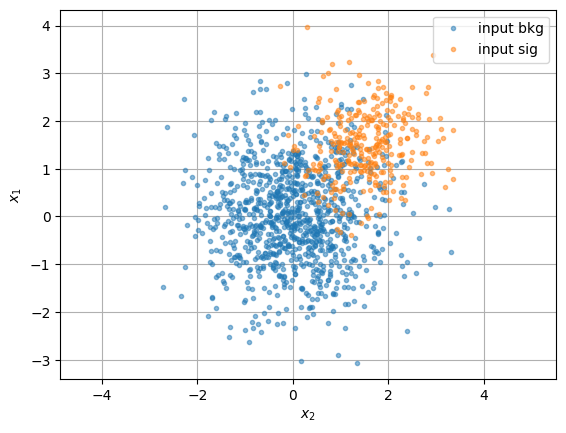

In [19]:
# Let's create a toy dataset that contains samples from two overlapping 2D Gaussian distributions
# We will call the Gaussian with mean 0 and variance 1 background, and a Gaussian with mean 2 and variance 0.5 signal
# Note we have a diagonal covariance matrix, so the two dimensions are uncorrelated. Make this more complicated if you want to!

bkg_dist = torch.distributions.MultivariateNormal(loc=torch.tensor([0.0, 0.0]), covariance_matrix=torch.tensor([[1.0, 0.0], [0.0, 1.0]]))
sig_dist = torch.distributions.MultivariateNormal(loc=torch.tensor([1.5, 1.5]), covariance_matrix=torch.tensor([[0.5, 0.0], [0.0, 0.5]]))

# input_bkg is 500 samples from a gaussian of N(0,1)
N_bkg = 1000
input_bkg = bkg_dist.sample((N_bkg,))

# input_sig is 500 samples from a gaussian of N(1.5,0.5)
N_sig = 300
input_sig = sig_dist.sample((N_sig,))

# Plot input_x1 and input_x2
plt.plot(input_bkg[:, 0], input_bkg[:, 1], '.', alpha=0.5, label="input bkg")
plt.plot(input_sig[:, 0], input_sig[:, 1], '.', alpha=0.5, label="input sig")
plt.axis('equal')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.grid()
plt.legend()
plt.show()

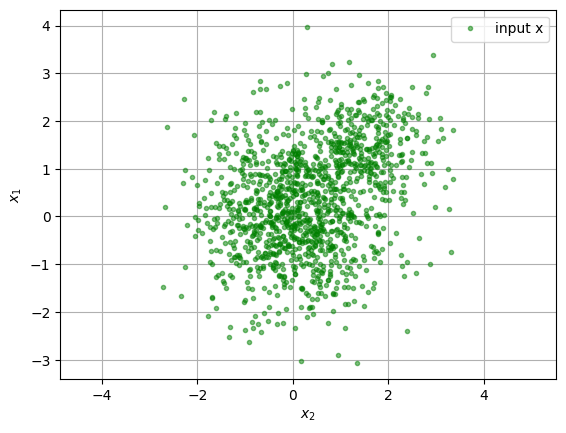

In [22]:
# We know what points are samples from which distribution, but in real world examples we don't, so let's pretend and put the data together in a single array.
# This data will be used as input to machine learning models in what follows.

## YOUR CODE HERE: create a tensor of shape (N_bkg + N_sig, 2) that contains the background and signal samples together
input_x = torch.cat([input_bkg, input_sig], dim=0) # because it's N_bkg+N_sig, so use dim=0, cat-ing on rows.

# Plot input_x

plt.plot(input_x[:, 0], input_x[:, 1], '.', c="green", alpha=0.5, label="input x")
plt.axis('equal')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.grid()
plt.legend()
plt.show()

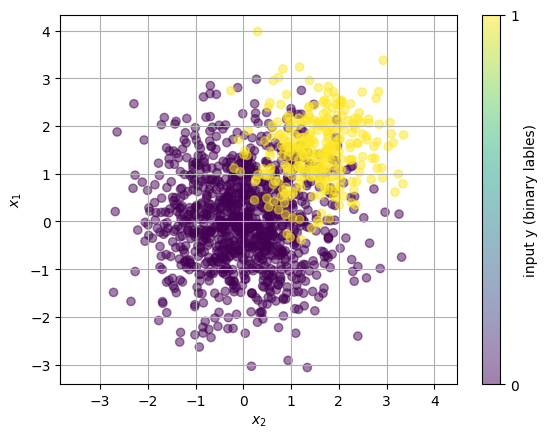

In [38]:
# In supervised learning, we have a dataset with class labels that we can use to calculate a loss function and train the model.
# Let's build these labels.

label_bkg = torch.zeros(input_bkg.shape[0])  # Assign label 0 to input_x1
label_sig = torch.ones(input_sig.shape[0])  # Assign label 1 to input_x2

input_y = torch.cat([label_bkg, label_sig], dim=0).unsqueeze(-1) # adds a dimension

# Plot input_y on the z-axis

sc = plt.scatter(input_x[:, 0], input_x[:, 1], c=input_y.flatten(), cmap='viridis', alpha=0.5)
plt.axis('equal')
plt.grid()
cbar = plt.colorbar(sc, ticks=[0, 1])  # Set the colorbar ticks to only show 0 and 1
cbar.set_label('input y (binary lables)')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.show()

Now we have some data.
Let's see what we can do with PyTorch's gradients, first starting with a very simple linear model.
Let's define $y = \sigma(Ax + b)$, where $x$ will be a sample from our 2D data distribution, $A$ and $b$ will be the parameters of our model, $\sigma$ represents the sigmoid function, and $y$ will be interpreted as a probability that the data sample $x$ belongs to the signal class.

In [57]:
# Define the parameters of our model
A = torch.randn(2, 1, requires_grad=True, dtype=torch.float32)  # We'll initialize our parameters to samples from a normal distribution
b = torch.randn(1, requires_grad=True, dtype=torch.float32)

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Define the model
def model(x):
    return sigmoid(x @ A + b)

In [58]:
# Let's perform a forward pass through our model
out = model(input_x[0,:])
print(f"out: {out}")

out: tensor([0.9297], grad_fn=<MulBackward0>)


The next thing we need is a loss function.
We'll use the binary cross entropy loss, which is standard in binary classification tasks:

$$
L[f] = \frac{1}{N} \sum_{i}^N y_i \log(f(x_i)) + (1 - y_i) \log(1 - f(x_i))
$$

where $f$ is the model, $x_i$ is the data, and $y_i$ is a class label (0 for background, 1 for signal).

In [59]:
def loss_fn(y_pred, y_true):
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

In [60]:
# Let's compute the loss
loss = loss_fn(out, input_y[0])
print(f"label: {input_y[0]}")
print(f"prediction: {out}")
print(f"loss: {loss}")

label: tensor([0.])
prediction: tensor([0.9297], grad_fn=<MulBackward0>)
loss: 2.6548125743865967


In [61]:
# We can now compute the gradient of the loss with respect to the parameters of our model
loss.backward()

print(f"dL/dA: {A.grad}")
print(f"dL/db: {b.grad}")

dL/dA: tensor([[-0.5186],
        [-0.0599]])
dL/db: tensor([0.9297])


The last piece is to optimize our model parameters to solve the binary classification task.
In realistic tasks it is always best to use off the shelf optimizers which contain many, many tricks to get good convergence in difficult optimization problems.
However this first example is so simple that we can optimize the parameters ourselves in a few lines of code, and write our very first training loop along the way.
We will implement very simple gradient descent, with no batching.

In [62]:
lr = 1e-4
max_grad = 10
losses = []

# We'll run a maximum of 1000 iterations
for i in range(5001):

    # Forward pass
    out = model(input_x)

    # Compute the loss
    loss = loss_fn(out, input_y)
    losses.append(loss.item())

    # Backward pass
    loss.backward()

    # Update the parameters
    # In a realistic case, we would replace these lines with a call to a real optimizer
    # Note I am clipping the gradients here to avoid large gradients that can cause numerical instability
    # What happens if you don't do this?
    A.data -= lr * A.grad.clip(min=-max_grad, max=max_grad)
    b.data -= lr * b.grad.clip(min=-max_grad, max=max_grad)

    if loss < 0.1:
        print(f"Loss is below 0.1, stopping training")
        break

print(f"Ran for {i} iterations")
print(f"Final loss: {loss.item()}")
print(f"Final A: {A.detach().numpy()}")
print(f"Final b: {b.detach().numpy()}")

Ran for 5000 iterations
Final loss: 0.2503240704536438
Final A: [[1.3801777]
 [1.1667131]]
Final b: [-2.8279202]


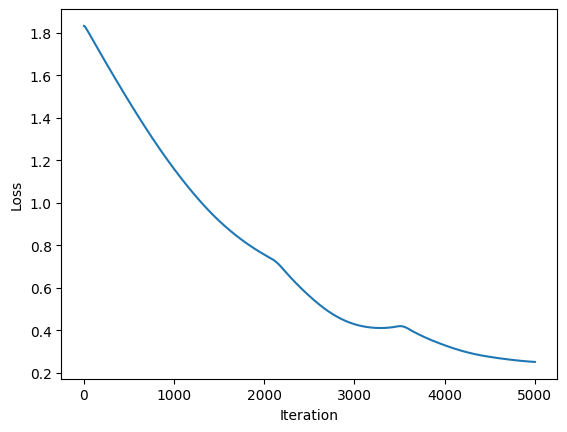

In [63]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

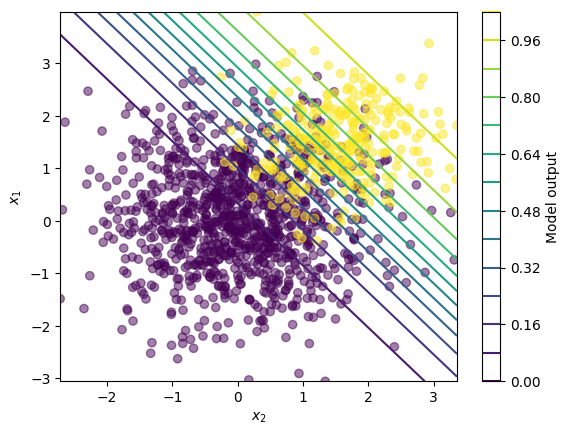

In [64]:
# Let's plot the model output as a function of the 2D input space to see if we learned something useful
x1 = np.linspace(input_x[:,0].min(), input_x[:,0].max(), 100)
x2 = np.linspace(input_x[:,1].min(), input_x[:,1].max(), 100)

X1, X2 = np.meshgrid(x1, x2)

X = np.vstack([X1.flatten(), X2.flatten()]).T

X = torch.tensor(X, dtype=torch.float32)
Y = model(X).detach().numpy()

ctr = plt.contour(X1, X2, Y.reshape(100, 100), levels=15, cmap='viridis')
sc = plt.scatter(input_x[:, 0], input_x[:, 1], c=input_y.flatten(), cmap='viridis', alpha=0.5)
cbar = plt.colorbar(ctr)
cbar.set_label('Model output')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.show()

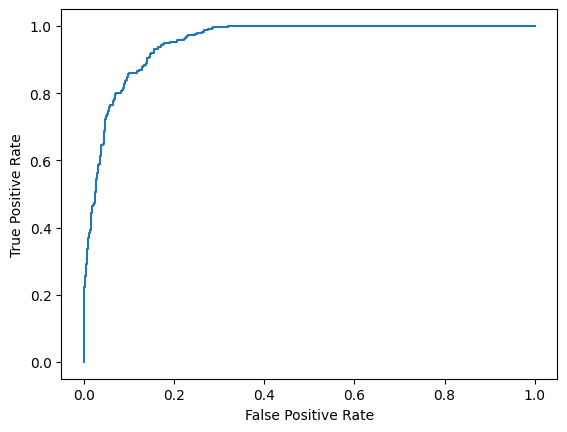

AUC: 0.9528733333333333


In [65]:
# We can also calculate a ROC curve and the area under to get a performance metric
# Get the model output for the entire data set
y_pred_linear = model(input_x).detach().numpy()

# Get the ROC curve
fpr_linear, tpr_linear, thresholds_linear = sklearn.metrics.roc_curve(input_y, y_pred_linear)

# Plot the ROC curve
plt.plot(fpr_linear, tpr_linear)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Get the area under the ROC curve
auc = sklearn.metrics.auc(fpr_linear, tpr_linear)

print(f"AUC: {auc}")

Remember AUC ranges between 0.5 (random guessing) and 1.0 so this isn't too bad at all.
This is a linear model, so we should obviously expect that our network output should be linear, i.e. the contours of the 2D functions are straight lines.
Note I had to fiddle a bit with the parameters above to get reliably decent results.
It should be not at all hard to break, which you should try!

So that's a simple linear model, but on real world tasks this won't get you very far.
Let's move on and solve this toy problem for good.

## Deep Learning

For all things deep learning, PyTorch has a `torch.nn` module that contains nearly all of the building blocks you might need implemented for you.
Fundamental to the module is the `torch.nn.Module` class, which is the base class for all neural network pieces, and neural networks as a whole.
Whenever you start to write a neural network from scratch in PyTorch, the first thing to do is subclass `torch.nn.Module` and implement two methods:
- `__init__`: The constructor method. Here you'll initialize all of the network layers
- `forward`: Define the forward pass of the network. This function should take an input tensor as an argument, which is the data of the mini-batch, pass the tensor through the layers of the network, and then return the network output.

In [66]:
class BinaryClassifierNN(torch.nn.Module):
    """
    A simple neural network with two hidden layers.
    """

    # The constructor method, initialize the network layers
    def __init__(self, input_dim, hidden_dim):
        super().__init__()  # Always be sure to call the parent constructor!
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1),
            torch.nn.Sigmoid()
        )

    # The forward pass of the network
    def forward(self, x):
        return self.linear_stack(x)

In [67]:
# Initialize the network and print a summary using torchinfo
model = BinaryClassifierNN(input_dim=2, hidden_dim=50)
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
BinaryClassifierNN                       --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       150
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       2,550
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       51
│    └─Sigmoid: 2-6                      --
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0

In [68]:
# Let's check that we can run a forward pass with our model
## YOUR CODE HERE: run a forward pass through the model, just to check that we can get outputs
f = model.forward(input_x)
f

tensor([[0.5213],
        [0.5157],
        [0.4843],
        ...,
        [0.4744],
        [0.4817],
        [0.4601]], grad_fn=<SigmoidBackward0>)

The next improvement is to use a proper optimizer.
There are a whole host of them implemented in the package `torch.optim` with even more implemented by someone else on github.
A very common starting point is `Adam`.
If you're training something big and need efficiency or to squeeze out every last bit of performance there are better options, but Adam will work great here.

In [70]:
lr = 1e-4
# Re-initializing the model here so you don't end up with an optimizer for a different model that's now out of scope (tricky in jupyter notebooks)
model = BinaryClassifierNN(input_dim=2, hidden_dim=50)
optim = torch.optim.Adam(model.parameters(), lr=lr)

Now for the training loop!
It is conceptually identical to what we did above.
We just rely on the optimizer instead of adjusting the parameters of the model manually.

In [71]:
lr = 1e-3
max_epochs = 1000
losses = []

# Epoch loop
for epoch in tqdm.tqdm(range(max_epochs)):

    # Zero the gradients from the previous batch. Don't forget this!
    optim.zero_grad()

    ## YOUR CODE HERE: implement the forward and backward pass needed to train the model

    # 1. Forward pass
    out = model(input_x)

    # 2. Compute the loss
    loss = loss_fn(out, input_y)
    losses.append(loss.item())

    # 3. Backward pass
    loss.backward()

    # Update the model parameters
    optim.step()

    losses.append(loss.item())


100%|██████████| 1000/1000 [00:02<00:00, 452.39it/s]


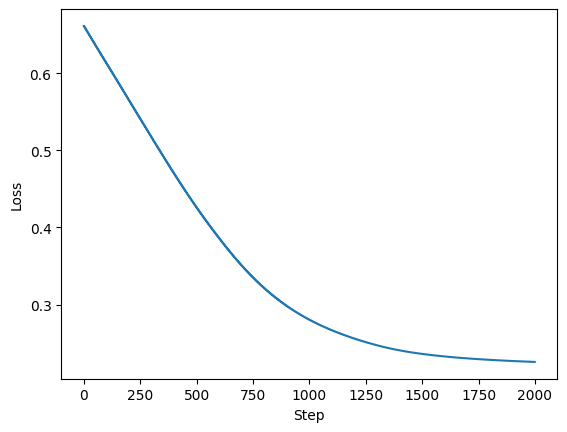

In [72]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()

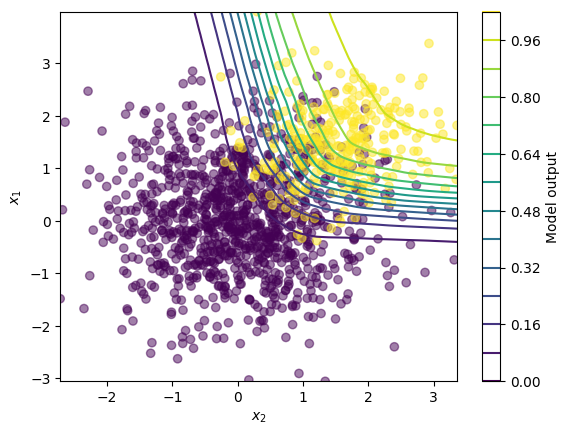

In [73]:
# Let's plot the contours of the NN output
x1 = np.linspace(input_x[:,0].min(), input_x[:,0].max(), 100)
x2 = np.linspace(input_x[:,1].min(), input_x[:,1].max(), 100)

X1, X2 = np.meshgrid(x1, x2)

X = np.vstack([X1.flatten(), X2.flatten()]).T

X = torch.tensor(X, dtype=torch.float32)
Y = model(X).detach().numpy()

ctr = plt.contour(X1, X2, Y.reshape(100, 100), levels=15, cmap='viridis')
sc = plt.scatter(input_x[:, 0], input_x[:, 1], c=input_y.flatten(), cmap='viridis', alpha=0.5)
cbar = plt.colorbar(ctr)
cbar.set_label('Model output')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.show()

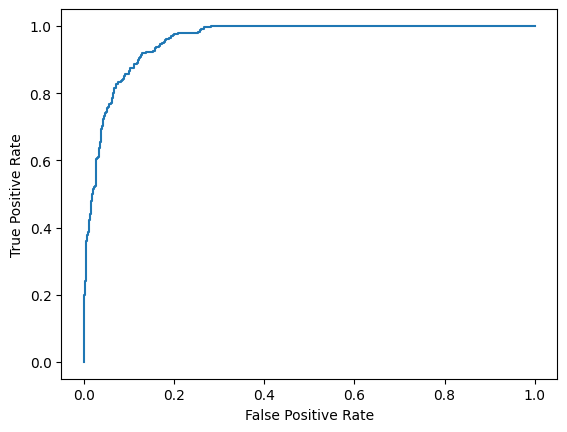

AUC: 0.9586033333333334


In [74]:
# We can also calculate a ROC curve and the area under to get a performance metric
# Get the model output for the entire data set
## YOUR CODE HERE: get the model output for the entire data set
## y_pred_nn = ...
y_pred_nn = model(input_x).detach().numpy()

# Get the ROC curve
fpr_nn, tpr_nn, thresholds_nn = sklearn.metrics.roc_curve(input_y, y_pred_nn)

# Plot the ROC curve
plt.plot(fpr_nn, tpr_nn)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Get the area under the ROC curve
auc_nn = sklearn.metrics.auc(fpr_nn, tpr_nn)

print(f"AUC: {auc_nn}")

Congrats!
You've trained for first deep learning model.
You should hopefully see that the network has learned a non-linear solution, and that your separation power, quantified by the AUC, is a bit higher.
One a toy dataset like this the results aren't so impressive, but as you'll see the power of this technology is in scale.

## Bonus: an analytic solution and a sad truth

There is one last lesson we can learn from this toy problem.
It is actually simple enough that it has an analytic solution.
What this solution is and how to calculate it is a bit beyond the scope here (you're almost always just going to learn these things from data anyway!), but very briefly the correct solution is a rescaling of the likelihood ratio between the signal and background distributions, both of which we know are simple 2D Gaussians.
We can use the `torch.distributions` package to evaluate the likelihoods numerically.

In [75]:
# Define a function for calculating the analytic solution at a given point
def analytic_solution(x):
    """ not the input x is a 1D torch tensor with shape (2,) """
    llr = sig_dist.log_prob(x) - bkg_dist.log_prob(x)
    return torch.exp(llr) / (1 + torch.exp(llr))

AUC model: 0.9586033333333334
AUC analytic: 0.9578833333333333


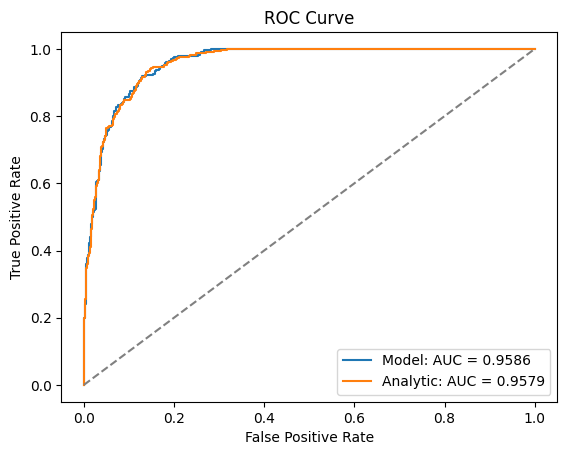

In [76]:
# What ROC curve and AUC do we get for the analytic solution?
analytic_pred = analytic_solution(input_x)

# Calculate the ROC curve
fpr_analytic, tpr_analytic, thresholds_analytic = sklearn.metrics.roc_curve(input_y, analytic_pred)

# Calculate the AUC
auc_analytic = sklearn.metrics.auc(fpr_analytic, tpr_analytic)
print(f"AUC model: {auc_nn}")
print(f"AUC analytic: {auc_analytic}")

# Plot the ROC curve
plt.plot(fpr_nn, tpr_nn, label=f"Model: AUC = {auc_nn:.4f}")
plt.plot(fpr_analytic, tpr_analytic, label=f"Analytic: AUC = {auc_analytic:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The NN is likely getting a slightly higher AUC than the analytic solution. The problem is that the NN is only getting a better AUC on the dataset we explicitly trained it on. What if we sample a larger data set and try again?

AUC model: 0.9597
AUC analytic: 0.9615


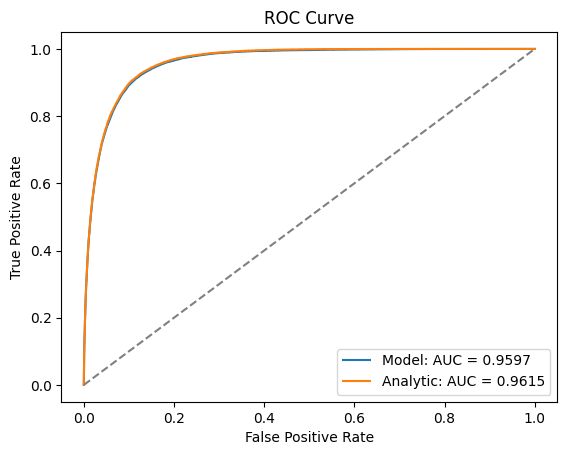

In [77]:
# Let's try resampling the data
N_bkg = 100000
N_sig = 30000
input_bkg = bkg_dist.sample((N_bkg,))
input_sig = sig_dist.sample((N_sig,))
input_x = torch.cat([input_bkg, input_sig], dim=0)
input_y = torch.cat([torch.zeros(N_bkg), torch.ones(N_sig)], dim=0)
analytic_pred = analytic_solution(input_x)
nn_pred = model(input_x).detach().numpy()

# Calculate the ROC curve
fpr_analytic, tpr_analytic, thresholds_analytic = sklearn.metrics.roc_curve(input_y, analytic_pred)
fpr_nn, tpr_nn, thresholds_nn = sklearn.metrics.roc_curve(input_y, nn_pred)

# Calculate the AUC
auc_analytic = sklearn.metrics.auc(fpr_analytic, tpr_analytic)
auc_nn = sklearn.metrics.auc(fpr_nn, tpr_nn)
print(f"AUC model: {auc_nn:.4f}")
print(f"AUC analytic: {auc_analytic:.4f}")

# Plot the ROC curve
plt.plot(fpr_nn, tpr_nn, label=f"Model: AUC = {auc_nn:.4f}")
plt.plot(fpr_analytic, tpr_analytic, label=f"Analytic: AUC = {auc_analytic:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Now you should see the the model's AUC is a bit lower than the analytic solution.
We're starting to see "over-training", where the model starts to memorize your dataset, and we'll cover how to deal with it in the next lecture.
So the analytic solution seems to work.
Let's plot it:

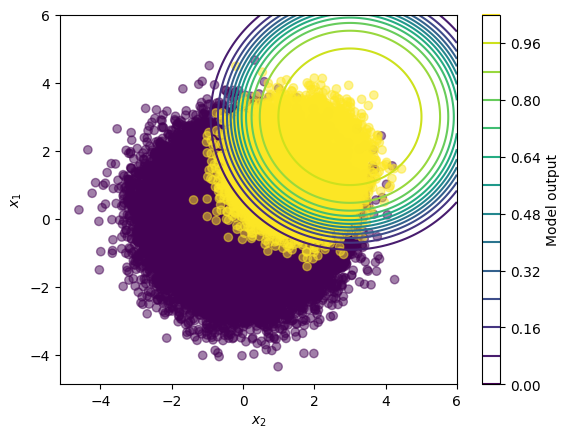

In [78]:
# Plot the analytic solution, in an expanded range to see the full shape
x1 = np.linspace(-3, 6, 200)
x2 = np.linspace(-3, 6, 200)

X1, X2 = np.meshgrid(x1, x2)

X = np.vstack([X1.flatten(), X2.flatten()]).T

X = torch.tensor(X, dtype=torch.float32)
Y = analytic_solution(X).detach().numpy()

ctr = plt.contour(X1, X2, Y.reshape(200, 200), levels=15, cmap='viridis')
sc = plt.scatter(input_x[:, 0], input_x[:, 1], c=input_y.flatten(), cmap='viridis', alpha=0.5)
cbar = plt.colorbar(ctr)
cbar.set_label('Model output')
plt.ylabel(r"$x_1$")
plt.xlabel(r"$x_2$")
plt.show()

This is not very similar to what the NN learned!
Unsurprisingly the NN only learned the solution in the region of phase space where there is training data.
Outside of this region, the ML based solution is entirely unhelpful.
This is just an elaborate way to make the obvious statement that ML can only help you where you have data.
In most cases we can ignore this detail and everything will be fine, but it is good to recognize the fundamental limitations of the approach before we add more layers of complexity, which we will do next.